<a href="https://colab.research.google.com/github/fovi-llc/refactor-python/blob/main/konwinski-prize-gemma-llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has a few tweaks to run in Colab.  Training one fold on an A100 takes about 3 minutes (vs 27 on Kaggle).

The original is at https://www.kaggle.com/code/akhiljethwa/konwinski-prize-gemma-llm

In [1]:
!pip install -U kagglehub colorama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.5
    Uninstalling kagglehub-0.3.5:
      Successfully uninstalled kagglehub-0.3.5


In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

konwinski_prize_path = kagglehub.competition_download('konwinski-prize')
keras_gemma_keras_gemma_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_2b_en/2')

print('Data source import complete.')
konwinski_prize_path

100%|██████████| 123M/123M [00:00<00:00, 277MB/s]

Extracting files...


Data source import complete.


'/root/.cache/kagglehub/competitions/konwinski-prize'

In [4]:
# Install K-prize packages for Colab or JupyterLab.  Not needed for Kaggle env.

!cp -R {konwinski_prize_path}/kaggle_evaluation .
!pip install {konwinski_prize_path}/kprize_setup/kprize-1.0.0-py3-none-any.whl

Processing /root/.cache/kagglehub/competitions/konwinski-prize/kprize_setup/kprize-1.0.0-py3-none-any.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 42.1 MB/s eta 0:00:00
  Attempting


![](https://opengraph.githubassets.com/589594f788a4448dfe547f5999a901ce44b94d851559d036df16766e02a2ef62/swe-bench/SWE-bench)

# Data Overview

data/data.parquet The train set metadata, which includes a limited to a handful of examples. You are encouraged to source additional codebases for training your models. Most of the metadata provided here is only available for the train set.

- instance_id - A unique string identifier for the instance (aka GitHub issue).
- repo - The relevant GitHub repository. Also served by the evaluation API.
- problem_statement - Text describing the issue. Also served by the evaluation API.
- patch - Only provided for the train set. The patch resolving the issue.
- test_patch - Only provided for the train set. The patch resolving the issue.
- pull_number - The PR number of the pull request resolving the issue.
- base_commit - The commit used as the basis for the provided copy of the repo.
- issue_numbers - The original ID number of the issue.
- [PASS_TO_PASS/FAIL_TO_PASS] - Lists of the unit tests to run for this issue.

### Imports:

In [5]:
import kaggle_evaluation.konwinski_prize_inference_server
import zipfile
import pandas as pd
from datasets import load_dataset
import os
import shutil
import io
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [6]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('seaborn-v0_8-pastel')

## Competition Dataset

In [7]:
import zipfile
konwinski= zipfile.ZipFile(konwinski_prize_path + '/data.a_zip')
konwinski.extractall()

In [8]:
# zf = zipfile.ZipFile('../input/konwinski-prize/data.a_zip')

train_data = pd.read_parquet("data/data.parquet")

In [9]:
train_data.head(10)

,instance_id,repo,problem_statement,patch,test_patch,pull_number,base_commit,PASS_TO_PASS,FAIL_TO_PASS,issue_numbers
0,pylint-dev__astroid-2496,pylint-dev/astroid,TypeError: unsupported format string passed to...,diff --git a/ChangeLog b/ChangeLog\nindex 4560...,diff --git a/tests/test_inference.py b/tests/t...,2496,8d3cdbbe6685fd8cf211816bec56c90f38f1859e,[tests/test_inference.py::InferenceUtilsTest::...,[tests/test_inference.py::test_formatted_fstri...,[2492]
1,pylint-dev__astroid-2468,pylint-dev/astroid,Pylint checks against incorrect type with prop...,diff --git a/ChangeLog b/ChangeLog\nindex fdbb...,diff --git a/tests/test_inference.py b/tests/t...,2468,6db3a60553ff538a936d5dda23d67a3924a57f45,[tests/test_inference.py::InferenceUtilsTest::...,[tests/test_inference.py::InferenceTest::test_...,[2467]
2,astropy__astropy-17048,astropy/astropy,QTable cannot take `dimensionless_unscaled` wh...,diff --git a/astropy/table/table.py b/astropy/...,diff --git a/astropy/table/tests/test_table.py...,17048,d60f6b72cd525262bfd179331d9fe4474177918f,[astropy/table/tests/test_table.py::TestSetTab...,[astropy/table/tests/test_table.py::test_qtabl...,[17047]
3,astropy__astropy-16898,astropy/astropy,BUG: tables do not deal well with zero-sized s...,diff --git a/astropy/io/registry/core.py b/ast...,diff --git a/astropy/io/fits/tests/test_connec...,16898,ee6d087baf301c1d08db92e6e5b6d909d57e6fac,[astropy/io/fits/tests/test_connect.py::TestSi...,[astropy/io/fits/tests/test_connect.py::test_z...,[16897]
4,astropy__astropy-16830,astropy/astropy,KeyError: 'version_1_3_or_later' when parsing ...,diff --git a/astropy/io/votable/tree.py b/astr...,diff --git a/astropy/io/votable/tests/test_tre...,16830,e39f486fec48d87aa3677326167954370d7a7bf9,[astropy/io/votable/tests/test_tree.py::test_c...,[astropy/io/votable/tests/test_tree.py::test_v...,"[16825, 16826]"
5,astropy__astropy-16812,astropy/astropy,Provide a way to make a copy of a model with d...,diff --git a/astropy/modeling/core.py b/astrop...,diff --git a/astropy/modeling/tests/test_core....,16812,c241103c11954d3c1cfe3c1840b1ece72479c522,[astropy/modeling/tests/test_core.py::test_Mod...,[astropy/modeling/tests/test_core.py::test_res...,[16593]


## Origional Dataset:

In [10]:
swebench = load_dataset('princeton-nlp/SWE-bench', split='test')

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/225 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2294 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/19008 [00:00<?, ? examples/s]

In [11]:
swebench

Dataset({
    features: ['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
    num_rows: 2294
})

In [12]:
# Convert the dataset to a pandas DataFrame
swebench = swebench.to_pandas()

In [13]:
swebench.head()

,repo,instance_id,base_commit,patch,test_patch,problem_statement,hints_text,created_at,version,FAIL_TO_PASS,PASS_TO_PASS,environment_setup_commit
0,astropy/astropy,astropy__astropy-11693,3832210580d516365ddae1a62071001faf94d416,diff --git a/astropy/wcs/wcsapi/fitswcs.py b/a...,diff --git a/astropy/wcs/wcsapi/tests/test_fit...,'WCS.all_world2pix' failed to converge when pl...,Welcome to Astropy 👋 and thank you for your fi...,2021-05-04T10:05:33Z,4.2,"[""astropy/wcs/wcsapi/tests/test_fitswcs.py::te...","[""astropy/wcs/wcsapi/tests/test_fitswcs.py::te...",3832210580d516365ddae1a62071001faf94d416
1,astropy/astropy,astropy__astropy-12057,b6769c18c0881b6d290e543e9334c25043018b3f,diff --git a/astropy/nddata/nduncertainty.py b...,diff --git a/astropy/nddata/tests/test_nduncer...,Add helpers to convert between different types...,See also #10128 which is maybe not exactly the...,2021-08-14T10:06:53Z,4.3,"[""astropy/nddata/tests/test_nduncertainty.py::...","[""astropy/nddata/tests/test_nduncertainty.py::...",298ccb478e6bf092953bca67a3d29dc6c35f6752
2,astropy/astropy,astropy__astropy-12318,43ce7895bb5b61d4fab2f9cc7d07016cf105f18e,diff --git a/astropy/modeling/physical_models....,diff --git a/astropy/modeling/tests/test_physi...,BlackBody bolometric flux is wrong if scale ha...,I forgot who added that part of `BlackBody`. I...,2021-10-28T15:32:17Z,4.3,"[""astropy/modeling/tests/test_physical_models....","[""astropy/modeling/tests/test_physical_models....",298ccb478e6bf092953bca67a3d29dc6c35f6752
3,astropy/astropy,astropy__astropy-12544,3a0cd2d8cd7b459cdc1e1b97a14f3040ccc1fffc,diff --git a/astropy/io/fits/connect.py b/astr...,diff --git a/astropy/io/fits/tests/test_connec...,Can Table masking be turned off?\n<!-- This co...,,2021-11-30T16:14:01Z,4.3,"[""astropy/io/fits/tests/test_connect.py::TestS...","[""astropy/io/fits/tests/test_connect.py::TestS...",298ccb478e6bf092953bca67a3d29dc6c35f6752
4,astropy/astropy,astropy__astropy-12825,43ee5806e9c6f7d58c12c1cb9287b3c61abe489d,diff --git a/astropy/table/column.py b/astropy...,diff --git a/astropy/table/tests/conftest.py b...,SkyCoord in Table breaks aggregate on group_by...,Hmm. Maybe the logic here needs fixing:\r\n\r\...,2022-02-05T12:13:44Z,4.3,"[""astropy/table/tests/test_groups.py::test_tab...","[""astropy/table/tests/test_groups.py::test_col...",298ccb478e6bf092953bca67a3d29dc6c35f6752


## Some Data Visualizations

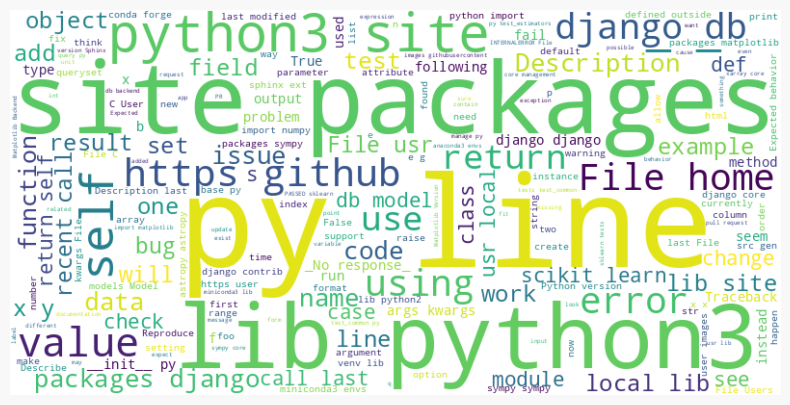

In [14]:
text = ' '.join(swebench['problem_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(14, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Statement Length')

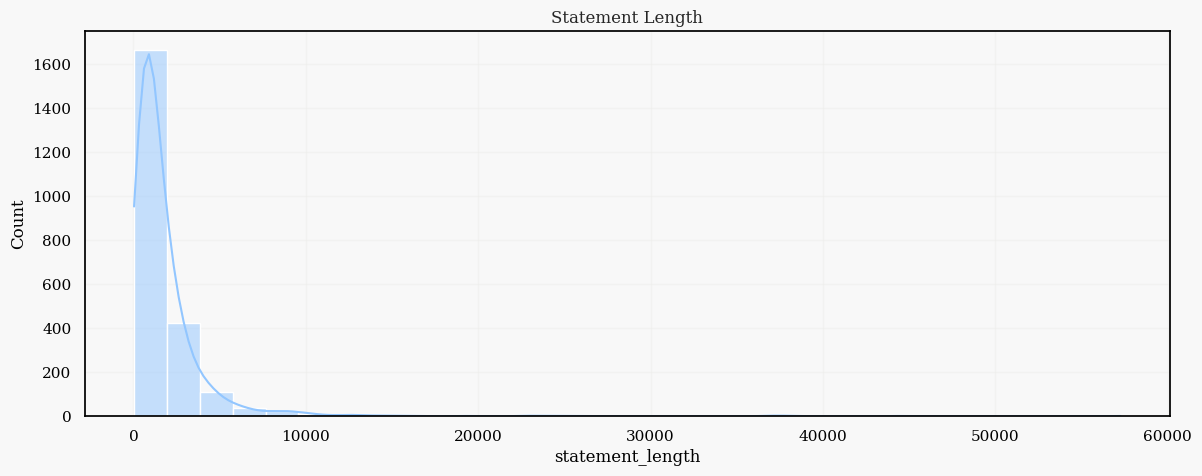

In [15]:
swebench['statement_length'] = swebench['problem_statement'].apply(len)
plt.figure(figsize=(14,5))
sns.histplot(x='statement_length', data=swebench, bins=30,kde=True)
plt.title('Statement Length')

Text(0.5, 1.0, 'Patch Length')

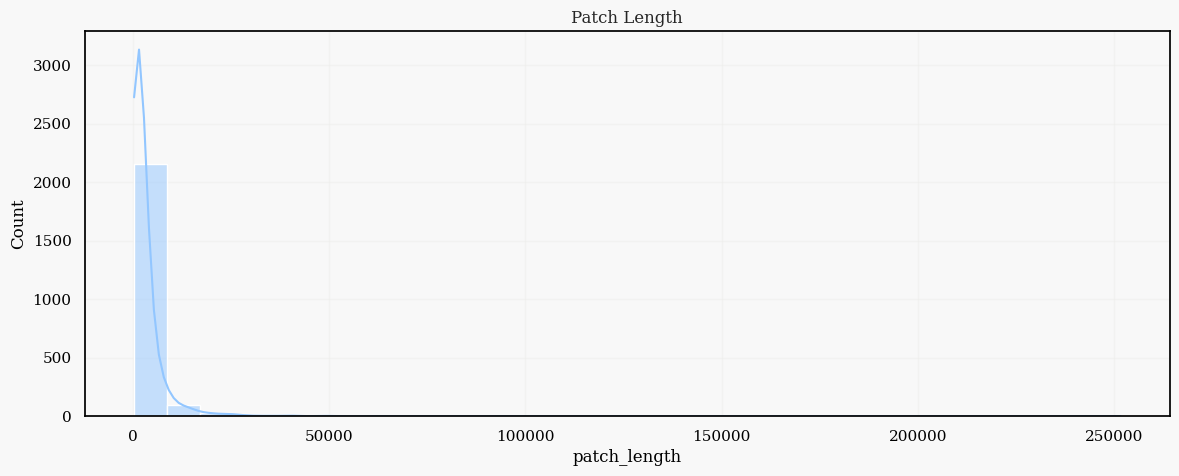

In [16]:
swebench['patch_length'] = swebench['patch'].apply(len)
plt.figure(figsize=(14,5))
sns.histplot(x='patch_length', data=swebench, bins=30,kde=True)
plt.title('Patch Length')

Text(0.5, 1.0, 'Statement Length vs Patch Length')

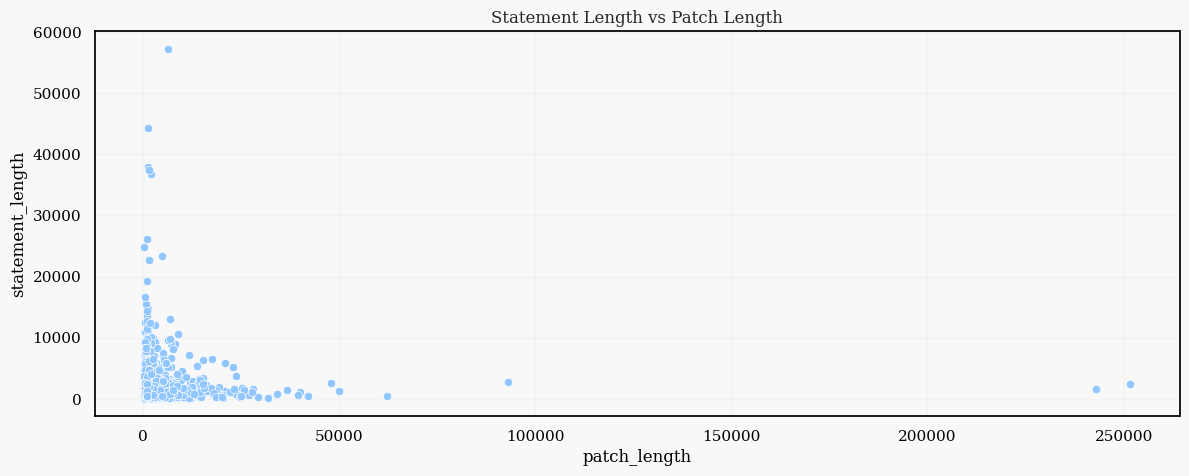

In [17]:
plt.figure(figsize=(14,5))
sns.scatterplot(data=swebench, x="patch_length", y="statement_length")
plt.title('Statement Length vs Patch Length')

In [18]:
swebench.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   repo                      2294 non-null   object
 1   instance_id               2294 non-null   object
 2   base_commit               2294 non-null   object
 3   patch                     2294 non-null   object
 4   test_patch                2294 non-null   object
 5   problem_statement         2294 non-null   object
 6   hints_text                2294 non-null   object
 7   created_at                2294 non-null   object
 8   version                   2294 non-null   object
 9   FAIL_TO_PASS              2294 non-null   object
 10  PASS_TO_PASS              2294 non-null   object
 11  environment_setup_commit  2294 non-null   object
 12  statement_length          2294 non-null   int64 
 13  patch_length              2294 non-null   int64 
dtypes: int64(2), object(12)


# Data Pre-processing

In [20]:
df = pd.DataFrame({'Question': swebench['problem_statement'], 'Answer': swebench['patch']})
df.info()
df

,Question,Answer
0,'WCS.all_world2pix' failed to converge when pl...,diff --git a/astropy/wcs/wcsapi/fitswcs.py b/a...
1,Add helpers to convert between different types...,diff --git a/astropy/nddata/nduncertainty.py b...
2,BlackBody bolometric flux is wrong if scale ha...,diff --git a/astropy/modeling/physical_models....
3,Can Table masking be turned off?\n<!-- This co...,diff --git a/astropy/io/fits/connect.py b/astr...
4,SkyCoord in Table breaks aggregate on group_by...,diff --git a/astropy/table/column.py b/astropy...
...,...,...
2289,"Rational calc value error\npython 3.11, sympy ...",diff --git a/sympy/core/numbers.py b/sympy/cor...
2290,"MatMul(x.T, OneMatrix(k, 1)).diff(x) causes Re...",diff --git a/sympy/tensor/array/expressions/ar...
2291,The evaluate=False parameter to `parse_expr` i...,diff --git a/sympy/parsing/sympy_parser.py b/s...
2292,Stats: Matrix Normal Distribution returns wron...,diff --git a/sympy/stats/matrix_distributions....


In [25]:
QNA_dataset = []

for index, row in df.iterrows():
    question, answer = row['Question'], row['Answer']
    template = (f"Question:\n{question}\n\nAnswer:\n{answer}")
    QNA_dataset.append(template)

# Gemma Fine Tuning

In [26]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

import os

os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

import keras
import keras_nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


## Import Model

In [27]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")

In [28]:
gemma_lm.backbone.enable_lora(rank=64)

In [29]:
gemma_lm.preprocessor.sequence_length = 512

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
    beta_1=0.9,
    beta_2=0.999
    )

optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

## Fine Tuning

In [30]:
%%time

gemma_lm.fit(QNA_dataset, epochs=1, batch_size=1)

2294/2294 ━━━━━━━━━━━━━━━━━━━━ 192s 72ms/step - loss: 1.3698 - sparse_categorical_accuracy: 0.6845
CPU times: user 3min 24s, sys: 1min 5s, total: 4min 30s
Wall time: 3min 14s


I have trained model for only 1 epoch since the dataset is very big and it takes several hours to fine tune the model on GPU.

# Submission

In [32]:
instance_count = None

def get_number_of_instances(num_instances: int) -> None:
    """ The very first message from the gateway will be the total number of instances to be served.
    You don't need to edit this function.
    """
    global instance_count
    instance_count = num_instances

### Custom `predict` function

In [33]:
first_prediction = True


def predict(problem_statement: str, repo_archive: io.BytesIO) -> str:
    """Inference function to generate a patch for a GitHub issue.

    Args:
        problem_statement (str): The text of the GitHub issue.
        repo_archive (io.BytesIO): A BytesIO buffer containing a .tar archive of the codebase.

    Returns:
        str: The generated patch as a string.
    """
    global first_prediction
    if not first_prediction:
        return None  # Skip the first issue.

    # Unpack the repository archive
    with open("repo_archive.tar", "wb") as f:
        f.write(repo_archive.read())
    repo_path = "repo"
    if os.path.exists(repo_path):
        shutil.rmtree(repo_path)
    shutil.unpack_archive("repo_archive.tar", extract_dir=repo_path)
    os.remove("repo_archive.tar")
    first_prediction = False

    # Generate a patch
    input_text = f"Problem:\n{problem_statement}\n\nPatch:"
    try:
        # Modify the generate call to remove unsupported arguments
        generated_patch = gemma_lm.generate([input_text])[0]
        return generated_patch
    except Exception as e:
        print(f"Error during generation: {e}")
        return "Error generating patch."


In [34]:
inference_server = kaggle_evaluation.konwinski_prize_inference_server.KPrizeInferenceServer(
    get_number_of_instances,
    predict
)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        data_paths=(
            konwinski_prize_path,  # Path to the entire competition dataset
            '/tmp/konwinski-prize-run/',   # Path to a scratch directory for unpacking data.a_zip.
        )
    )